# Репликация простой модели Linear Expenditure System
Данная работа является репликацией учебного примера из видео "Estimating the Linear Expenditure System in R "

Сссылка:https://www.youtube.com/watch?v=F68uDaaPjQA

Реплицировано на основе: https://github.com/EconJohn/Linear-Expenditure-System 

Данные по канадским домохозяйствам: https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3610022501

## Загрузка библиотек

In [57]:
#Нужна библиотека для чтения CSV
#Библиотека для работы с датафреймами
import pandas as pd
#Для простой регрессии
import statsmodels.formula.api as smf
#Для графиков
import matplotlib.pyplot as plt
#Нам нужен упорядоченный словарь для системы уравнений
from collections import OrderedDict
#Понадобится для добавления константы
import statsmodels.api as sm
#Для оценки систем одновременных уравнений
from linearmodels.system import SUR

## Работа с данными

In [58]:
#Загрузка Датафрейма
#ОБРАТИТЕ ВНИМАНИЕ, ЧТО В СЕПАРИРУЮЩИЙ ЗНАК = 	, Т.Е. ТАБУЛЯЦИЯ
#Подготовка данных
Canada = pd.read_csv(r'C:\Users\79618\Desktop\LES\Canada.txt', sep="	")
Canada=Canada.rename(columns={'Unnamed: 0': "Time"})
Canada=Canada.rename(columns={'Housing water electricity gas and other fuels': "Housing"})
Canada=Canada.rename(columns={'Water supply and sanitation services': "Water"})
Canada=Canada.rename(columns={'Paid rental fees for housing': "Paid_rental_fees"})
Canada=Canada.rename(columns={'Imputed rental fees for housing': "Imputed_rental_fees"})
Canada=Canada.rename(columns={'Materials for the maintenance and repair of the dwelling': "Materials_maintenance"})
Canada=Canada.rename(columns={'Services for the maintenance and repair of the dwelling': "Services_maintenance"})
Canada=Canada.rename(columns={'Other fuels': "Other_fuels"})
Canada

,Time,Housing,Paid_rental_fees,Imputed_rental_fees,Materials_maintenance,Services_maintenance,Water,Electricity,Gas,Other_fuels
0,1981,40096.0,9027.0,22794.0,644.0,35.0,666.0,3004.0,1552.0,2374.0
1,1982,45755.0,10290.0,25818.0,669.0,41.0,760.0,3452.0,2014.0,2711.0
2,1983,50456.0,11489.0,28798.0,708.0,42.0,843.0,3894.0,2244.0,2438.0
3,1984,54417.0,12367.0,31197.0,742.0,47.0,906.0,4400.0,2372.0,2386.0
4,1985,58557.0,13145.0,33667.0,802.0,51.0,966.0,4796.0,2572.0,2558.0
5,1986,62593.0,14114.0,36686.0,905.0,57.0,1059.0,5157.0,2476.0,2139.0
6,1987,66982.0,15245.0,39963.0,967.0,64.0,1150.0,5373.0,2330.0,1890.0
7,1988,73593.0,16582.0,43898.0,1009.0,72.0,1286.0,6166.0,2552.0,2028.0
8,1989,81163.0,18377.0,48658.0,1066.0,88.0,1457.0,6789.0,2560.0,2168.0
9,1990,87712.0,19989.0,52709.0,1076.0,98.0,1618.0,7308.0,2580.0,2334.0


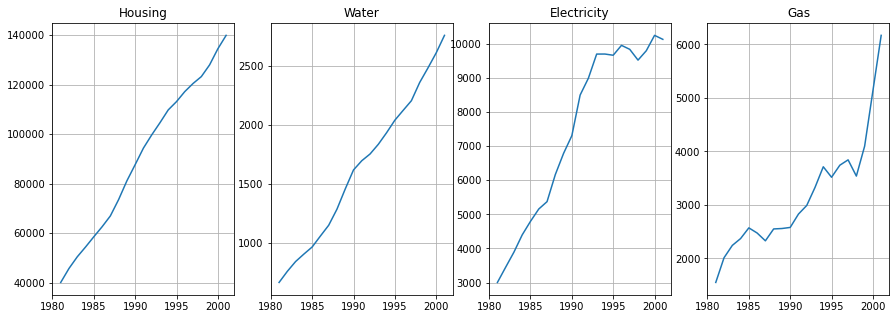

In [60]:
fig,axs=plt.subplots(1,4,figsize = (15, 5))
for i in range(4):
    axs[i].plot("Time",Canada.columns[[1,6,7,8,9][i]],data=Canada)
    axs[i].set(title=Canada.columns[[1,6,7,8,9][i]])
    axs[i].grid()

## Статистическая оценка

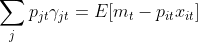

In [61]:
#Step2: Estimate of essential expenditure by obtaining fitted values over time
#Оценка абсолютно необходимых расходов (ниже которых нельзя потреблять)
reg=smf.ols(formula='Housing~Time',data=Canada)
results=reg.fit()

In [101]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Housing   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3081.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           1.73e-22
Time:                        22:50:02   Log-Likelihood:                -193.31
No. Observations:                  21   AIC:                             390.6
Df Residuals:                      19   BIC:                             392.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.989e+06   1.82e+05    -55.004      0.0

In [95]:
#Добавим эти fitted values в датафреймы
acon=results.fittedvalues
Canada['detrended']=Canada['Housing']-acon
Canada['Acon']=acon
Canada.head()

,const,Time,Housing,Paid_rental_fees,Imputed_rental_fees,Materials_maintenance,Services_maintenance,Water,Electricity,Gas,Other_fuels,detrended,Acon
0,1.0,1981,40096.0,9027.0,22794.0,644.0,35.0,666.0,3004.0,1552.0,2374.0,-74.658009,40170.658009
1,1.0,1982,45755.0,10290.0,25818.0,669.0,41.0,760.0,3452.0,2014.0,2711.0,521.560173,45233.439827
2,1.0,1983,50456.0,11489.0,28798.0,708.0,42.0,843.0,3894.0,2244.0,2438.0,159.778355,50296.221645
3,1.0,1984,54417.0,12367.0,31197.0,742.0,47.0,906.0,4400.0,2372.0,2386.0,-942.003463,55359.003463
4,1.0,1985,58557.0,13145.0,33667.0,802.0,51.0,966.0,4796.0,2572.0,2558.0,-1864.785281,60421.785281


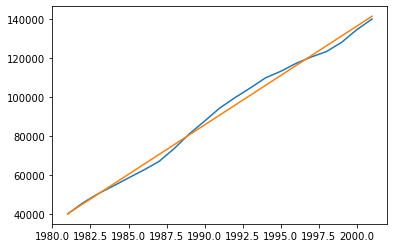

In [64]:
plt.plot("Time","Housing",data=Canada)
plt.plot(Canada["Time"],acon)

Далее проведелем оценку методом **Seemingly Unrelated Regressions (SUR)**

In [100]:
#Добавим константу
Canada=sm.add_constant(Canada)

**СОВПАЛО С РЕШЕНИЕМ В R!**

In [98]:
equations = OrderedDict()
equations['gasoline'] = {'dependent': Canada.Gas,
                         'exog': Canada[[ 'const','detrended']]}
equations['electricity'] = {'dependent': Canada.Electricity,
                         'exog': Canada[[ 'const','detrended']]}
equations['water'] = {'dependent': Canada.Water,
                         'exog': Canada[[ 'const','detrended']]}
mod = SUR(equations)

In [99]:
print(mod.fit(cov_type='unadjusted'))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.0512
No. Equations.:                     3   McElroy's R-squared:                 0.3049
No. Observations:                  21   Judge's (OLS) R-squared:             0.0512
Date:                Fri, Aug 12 2022   Berndt's R-squared:                  0.5682
Time:                        22:49:30   Dhrymes's R-squared:                 0.0512
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                 Equation: gasoline, Dependent Variable: Gas                  
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3150.6     229.18     13.747     0.0000      2701.4      3599.8
detrended   

**Интерпритация результатов:**

3150 (млн.$)- subsistence consumption ГАЗА в Канаде (Значима с почти нулевой p-value)

-0.0353 - снижение потребление газа по мере роста ????? (инфириорное блего, мало значима)